# Face Area Calculations

Computing and working with face areas is important for the analysis of unstructured grids, with many algorithms and workflows requiring them. This section will showcase the different face area calculation options provided with UXarray:

1. Calculate Total Face Area
2. Options for `Grid.calculate_total_face_area` Function
3. Getting Area of Individual Faces
4. Calculate Area of a Single Triangle in Cartesian Coordinates
5. Calculate Area from Multiple Faces in Spherical Coordinates
6. Demonstrate Area Correction at Line of Constant Lattitude

In [1]:
import uxarray as ux
import numpy as np

We will be using the `outCSne30.ug` grid file, which is encoded in the UGRID convention.

In [2]:
base_path = "../../test/meshfiles/"
grid_path = base_path + "/ugrid/outCSne30/outCSne30.ug"

ugrid = ux.open_grid(grid_path)
ugrid

<uxarray.Grid>
Original Grid Type: UGRID
Grid Dimensions:
  * n_node: 5402
  * n_face: 5400
  * n_max_face_nodes: 4
  * n_nodes_per_face: (5400,)
Grid Coordinates (Spherical):
  * node_lon: (5402,)
  * node_lat: (5402,)
Grid Coordinates (Cartesian):
Grid Connectivity Variables:
  * face_node_connectivity: (5400, 4)
Grid Descriptor Variables:
  * n_nodes_per_face: (5400,)

## 1. Calculate Total Face Area
We can calculate the total face area by calling the function `Grid.calculate_total_face_area()`. Since our dataset lies on the unit sphere, our expected area is 4π, which is approximately 12.56

In [3]:
t4_area = ugrid.calculate_total_face_area()
t4_area

np.float64(12.566370614678554)

## 2. Options for `Grid.calculate_total_face_area` Function

By default, `Grid.calculate_total_face_area` uses a Triangular Quadrature Rule and an Order of 4. However, you can specify the Quadrature Rule and Order as follows:


**Order:**

       1 to 10              for gaussian

       1, 4, 8, 10 and 12   for triangular


In [4]:
t1_area = ugrid.calculate_total_face_area(quadrature_rule="triangular", order=1)
t1_area

np.float64(12.571403993719983)

For the result above, notice that the area is slightly different than the first calculation we made.

Now we use Triangular Quadrature Rule and Order 1

Using a lower order is faster, but at the sacrifice of accuracy.

Generally, gaussian quadrature rule is more accurate than the triangular quadrature rule. Additionally, a higher order comes at the cost of computation time, but produces a more accurate result. See `uxarray/grid/area.py` file and function `get_gauss_quadratureDG` for details on quadrature points and weights.

## 3. Getting Area of Individual Faces

We can access the Grid attribute `Grid.face_area` to access the individual face areas. If you have not run a face area calculation yet, it will run the `Grid.compute_face_areas` and cache the value.



In [5]:
ugrid.face_areas

<xarray.DataArray 'face_areas' (n_face: 5400)> Size: 43kB
array([0.00211174, 0.00211221, 0.00210723, ..., 0.00210723, 0.00211221,
       0.00211174])
Dimensions without coordinates: n_face
Attributes:
    cf_role:    face_areas
    long_name:  Area of each face.

Now calculate the area again with the `Grid.compute_face_areas` function using arguments: quadrature_rule "gaussian" and order 4

In [6]:
all_face_areas, all_face_jacobians = ugrid.compute_face_areas(
    quadrature_rule="gaussian", order=4
)
g4_area = all_face_areas.sum()
g4_area

np.float64(12.566370614359112)

Now we compare the values with actual know value and report error for each of the three cases above.

In [7]:
actual_area = 4 * np.pi
diff_t4_area = np.abs(t4_area - actual_area)
diff_t1_area = np.abs(t1_area - actual_area)
diff_g4_area = np.abs(g4_area - actual_area)

diff_t1_area, diff_t4_area, diff_g4_area

(np.float64(0.005033379360810386),
 np.float64(3.1938185429680743e-10),
 np.float64(6.039613253960852e-14))

As we can see, it is clear that the Gaussian Quadrature Rule with Order 4 is the most accurate, and the Triangular Quadrature Rule with Order 1 is the least accurate.


## 4. Calculate Area of a Single Triangle in Cartesian Coordinates

For this section, we create a single triangle face with 3 vertices. By default, in `uxarray`, we assume that the coordinate system is spherical (lat / lon), however if you want to use cartesian coordinates, you must pass through `latlon = False` into the `Grid` constructor.

Assume the units in meters - this is a big triangle!

In [8]:
verts = [
    [
        [0.57735027, -5.77350269e-01, -0.57735027],
        [0.57735027, 5.77350269e-01, -0.57735027],
        [-0.57735027, 5.77350269e-01, -0.57735027],
    ]
]

# load our vertices into a UXarray Grid object
vgrid = ux.open_grid(verts, latlon=False)

vgrid

<uxarray.Grid>
Original Grid Type: Face Vertices
Grid Dimensions:
  * n_node: 3
  * n_face: 1
  * n_max_face_nodes: 3
  * n_nodes_per_face: (1,)
Grid Coordinates (Spherical):
Grid Coordinates (Cartesian):
  * node_x: (3,)
  * node_y: (3,)
  * node_z: (3,)
Grid Connectivity Variables:
  * face_node_connectivity: (1, 3)
Grid Descriptor Variables:
  * n_nodes_per_face: (1,)

In [9]:
vgrid.calculate_total_face_area()

np.float64(1.0719419938548218)

Additionally, if you are using a unit other than meters, you can update the units as follows

In [10]:
# Calculate the area of the triangle
area_gaussian = vgrid.calculate_total_face_area(quadrature_rule="gaussian", order=5)
area_gaussian

np.float64(1.0475702709086991)

## 5. Calculate Area from Multiple Faces in Spherical Coordinates

Similar to above, we can construct a `Grid` object with multiple faces by passing through a set of vertices. Here we define 3 six-sided faces.

In [11]:
faces_verts_ndarray = np.array(
    [
        np.array(
            [
                [150, 10, 0],
                [160, 20, 0],
                [150, 30, 0],
                [135, 30, 0],
                [125, 20, 0],
                [135, 10, 0],
            ]
        ),
        np.array(
            [
                [125, 20, 0],
                [135, 30, 0],
                [125, 60, 0],
                [110, 60, 0],
                [100, 30, 0],
                [105, 20, 0],
            ]
        ),
        np.array(
            [
                [95, 10, 0],
                [105, 20, 0],
                [100, 30, 0],
                [85, 30, 0],
                [75, 20, 0],
                [85, 10, 0],
            ]
        ),
    ]
)

We want our units to be spherical, so we pass through `latlon=True`. Additionally, if `latlon` is not passed through, it will default to spherical coordinates.

In [12]:
verts_grid = ux.open_grid(faces_verts_ndarray, latlon=True)

verts_grid

<uxarray.Grid>
Original Grid Type: Face Vertices
Grid Dimensions:
  * n_node: 14
  * n_face: 3
  * n_max_face_nodes: 6
  * n_nodes_per_face: (3,)
Grid Coordinates (Spherical):
  * node_lon: (14,)
  * node_lat: (14,)
Grid Coordinates (Cartesian):
Grid Connectivity Variables:
  * face_node_connectivity: (3, 6)
Grid Descriptor Variables:
  * n_nodes_per_face: (3,)

In [13]:
area, jacobian = verts_grid.compute_face_areas()
area

array([0.14323746, 0.25118746, 0.12141312])

## 6. Area Correction

The correction, \(A\), is calculated using the following formula:

```{math}
A = 2arctan(z(x_{1}y_{2} - x_{2} y_{1}) / {x_{1}^2 + y_{1}^2 + x_{1} x_{2} + y_{1} y_{2}) - z (x_{1} y_{2} - x_{2} y_{1} / x_{1} x_{2} + y_{1} y_{2}
```

### Where:
<ul>

<li>(x<sub>1</sub>, y<sub>1</sub>, z) are the Cartesian coordinates of the first node.</li>

<li>(x<sub>2</sub>, y<sub>2</sub>, z) are the Cartesian coordinates of the second node (note that the z coordinate is the same for both nodes).</li>

</ul>

### Assumptions:
- This formula assumes that the input coordinates \((x_1, y_1)\) and \((x_2, y_2)\) are normalized (i.e., they lie on the unit sphere).


For the same large triangle used in **Section 4**, we calculate the area correction term when an edge lies along the line of constant latitude.

### The following code:
- Plots the triangle.
- Marks the edges with different colors.
- Highlights the edge along the line of constant latitude.
- Marks the coordinates of the vertices.

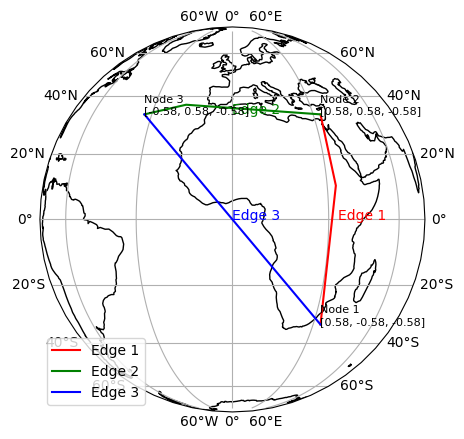

In [14]:
%matplotlib inline 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Convert the points to latitude and longitude
points = [
    (point[0] * 180 / 3.14159, point[1] * 180 / 3.14159)
    for vert in verts
    for point in vert
]

# Node names
node_names = ["Node 1", "Node 2", "Node 3"]

# Edge names and colors
edge_names = ["Edge 1", "Edge 2", "Edge 3"]
edge_colors = ["red", "green", "blue"]

# Create a new figure
fig = plt.figure(figsize=(10, 5))

# Create a GeoAxes in the Orthographic projection
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=0))

# Add coastlines and gridlines for reference
ax.add_feature(cfeature.COASTLINE)
ax.gridlines(draw_labels=True)

# Plot the points, edges, and labels
for i in range(len(points)):
    lon1, lat1 = points[i]
    lon2, lat2 = points[(i + 1) % len(points)]

    # Plot the edge
    ax.plot(
        [lon1, lon2],
        [lat1, lat2],
        color=edge_colors[i],
        transform=ccrs.Geodetic(),
        label=edge_names[i],
    )

    # Add edge label (adjust the offset as needed)
    ax.text(
        (lon1 + lon2) / 2,
        (lat1 + lat2) / 2,
        edge_names[i],
        transform=ccrs.Geodetic(),
        color=edge_colors[i],
    )

    # Add node label with Cartesian coordinates
    cartesian_coords = verts[0][i]  # Get Cartesian coordinates from verts
    label = f"{node_names[i]}\n[{cartesian_coords[0]:.2f}, {cartesian_coords[1]:.2f}, {cartesian_coords[2]:.2f}]"
    ax.text(lon1, lat1, label, transform=ccrs.Geodetic(), fontsize=8, color="black")

# Show the full globe
ax.set_global()

# Add a legend for the edges
plt.legend()

# Display the plot
plt.show()

The default for correcttion is False, so we set it to True to calculate the correction term.

In [15]:
# Area of the triangle with correction
area, jacobian = vgrid.compute_face_areas(quadrature_rule="gaussian", order=5)
area

array([1.04757027])

- **Edge 3** (blue) and **Edge 2** (green) of the triangle lie along lines of constant latitude.
- Without correction, the area is calculated as `1.047`. With the correction, the area becomes `1.047 + 2 * 0.140`, which gives the correct area of the triangle.


- **Edge 3** (red) also lies along a line of constant latitude but passes through the poles. Therefore, it is not considered for the correction term.

To compute the area with the correction term applied, pass the argument ``correct_area=True`` to the function call. This enables automatic adjustment for edges along lines of constant latitude.

In [16]:
# Continuing with our example from above and now we will correct the area
area = vgrid.compute_face_areas(quadrature_rule="gaussian", order=5, correct_area=True)

Check if edge passes through pole:  False
0.577350269522959 -0.5773502685229592 0.5773502695229592 0.577350268522959 -0.5773502695229591 correction: 0.1402978685558901
Edge is in the  Southern  hemisphere.
For Node 1  [ 0.57735027 -0.57735027 -0.57735027] 
 and Node 2 [ 0.57735027  0.57735027 -0.57735027] 
CORRECTION 0.1402978685558901
Check if edge passes through pole:  False
0.5773502695229592 0.577350268522959 -0.5773502695229594 0.5773502685229589 -0.5773502695229591 correction: 0.14029786955589052
Edge is in the  Southern  hemisphere.
For Node 1  [ 0.57735027  0.57735027 -0.57735027] 
 and Node 2 [-0.57735027  0.57735027 -0.57735027] 
CORRECTION 0.14029786955589052
Check if edge passes through pole:  True
AREA Before Correction 1.0475702709086991
AREA After Correction 1.3281660100204802


In [4]:
import numpy as np
node_lon = np.array([90.0, 90.0, 90.0, 80.0, 80.0, 80.0, 70.0, 70.0, 70.0, 82.0, 84.0, 77.0, 72.0, 82.0, 83.23076923076923, 80.0, 80.0])
node_lat = np.array([50.0, 40.0, 30.0, 50.0, 40.0, 30.0, 50.0, 40.0, 30.0, 48.0, 35.0, 32.0, 43.0, 48.0, 40.0, 40.0, 47.0])
face_node_connectivity = np.array(
    [
        [0, 1, 4, 3], [1, 2, 5, 4], [3, 4, 7, 6], [4, 5, 8, 7], [9, 10, 11, 12], [13, 14, 15, 16]
    ]
)

In [5]:
import uxarray as ux
uxgrid_tri_quad = ux.Grid.from_topology(
    node_lon=node_lon,
    node_lat=node_lat,
    face_node_connectivity=face_node_connectivity,
    fill_value=-1,
)

uxgrid_tri_quad.plot()

:Path   [Longitude,Latitude]

In [6]:
# four intersecting polygons
node_lon = np.array([88.0, 83.23076923076923, 80.0, 80.0])
node_lat = np.array([48.0, 40.0, 40.0, 47.0])


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Path   [Longitude,Latitude]
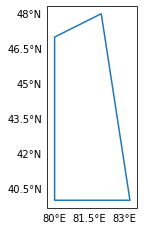

In [7]:
node_lon = np.array([  82.0, 83.23076923076923, 80.0, 80.0])
node_lat = np.array([ 48.0, 40.0, 40.0, 47.0])
face_node_connectivity = np.array(
    [
        [0, 1, 2, 3]
    ]
)
intersecting_face = ux.Grid.from_topology(
    node_lon=node_lon,
    node_lat=node_lat,
    face_node_connectivity=face_node_connectivity,
    fill_value=-1,
)
intersecting_face.plot(backend="matplotlib")

In [8]:
intersecting_face.compute_face_areas(quadrature_rule="gaussian", order=8, correct_area=True)

Check if edge passes through pole:  False
0.0902941982400847 0.7607043095695235 0.13302222155948906 0.7544065067354889 0.6427876096865393 correction: 5.6363324692706995e-06


calculated correction:  5.6363324692706995e-06
Edge is in the  Northern  hemisphere.
For Node 1  [0.0902942  0.76070431 0.64278761] 
 and Node 2 [0.13302222 0.75440651 0.64278761] 
CORRECTION 5.6363324692706995e-06
AREA Before Correction 0.004445818695731487
AREA After Correction 0.004451455028200758


(array([0.00445146]), array([0.00011306]))

In [1]:
import numpy as np
import uxarray as ux
def spherical_rectangle_area(lons, lats, radius=1):
    """
    Calculate the area of a spherical rectangle on a sphere.
    
    Parameters:
        lons (np.ndarray): Longitudes of the rectangle's corners (in degrees).
        lats (np.ndarray): Latitudes of the rectangle's corners (in degrees).
        radius (float): Radius of the sphere (default is unit sphere).
    
    Returns:
        float: Area of the spherical rectangle in steradians (or square units if radius is provided).
    """
    # Convert degrees to radians
    lons_rad = np.radians(lons)
    lats_rad = np.radians(lats)
    
    # Compute longitude and latitude differences
    delta_lambda = abs(lons_rad[0] - lons_rad[2])  # Assuming rectangular shape
    sin_phi_diff = abs(np.sin(lats_rad[0]) - np.sin(lats_rad[2]))
    
    # Calculate area
    area = radius**2 * delta_lambda * sin_phi_diff
    return area

# Define nodes
node_lon = np.array([90.0, 90.0, 10.0, 10.0])   # Longitudes in degrees
node_lat = np.array([80.0, 10.0, 10.0, 80.0])   # Latitudes in degrees

# Calculate the area
area_steradians = spherical_rectangle_area(node_lon, node_lat)
print(f"The area of the spherical rectangle is approximately {area_steradians:.6f} steradians")

# If Earth's radius is used (R ≈ 6371 km):
earth_radius_km = 6371
area_km2 = spherical_rectangle_area(node_lon, node_lat, radius=earth_radius_km)
print(f"The area of the spherical rectangle is approximately {area_km2:.2f} square kilometers")

# Define nodes
node_lon = np.array([90.0, 90.0, 10.0, 10.0])
node_lat = np.array([80.0, 10.0, 10.0, 80.0])

# Calculate the area
area = spherical_rectangle_area(node_lon, node_lat)
print(f"The area of the spherical rectangle is approximately {area:.6f} steradians")

The area of the spherical rectangle is approximately 1.132592 steradians
The area of the spherical rectangle is approximately 45971520.05 square kilometers
The area of the spherical rectangle is approximately 1.132592 steradians


In [2]:

# Define face-node connectivity
face_node_connectivity = np.array([
    [0, 1, 2, 3]
])

face = ux.Grid.from_topology(
    node_lon=node_lon,
    node_lat=node_lat,
    face_node_connectivity=face_node_connectivity,
    fill_value=-1,
)
face.plot(backend="bokeh")

:Path   [Longitude,Latitude]

In [3]:
face.compute_face_areas(quadrature_rule="gaussian", order=8, correct_area=True)

Check if edge passes through pole:  False
6.030208312509488e-17 0.984807753012208 0.9698463103929541 0.17101007166283433 0.17364817766693033 correction: 0.04692118879641144


calculated correction:  0.04692118879641144
Edge is in the  Northern  hemisphere.
For Node 1  [6.03020831e-17 9.84807753e-01 1.73648178e-01] 
 and Node 2 [0.96984631 0.17101007 0.17364818] 
CORRECTION 0.04692118879641144
Check if edge passes through pole:  False
0.1710100716628344 0.030153689607045817 1.0632884247878861e-17 0.17364817766693041 0.984807753012208 correction: 0.006156712978357515


calculated correction:  0.006156712978357515
Edge is in the  Northern  hemisphere.
For Node 1  [0.17101007 0.03015369 0.98480775] 
 and Node 2 [1.06328842e-17 1.73648178e-01 9.84807753e-01] 
CORRECTION -0.006156712978357515
AREA Before Correction 1.0918281804990866
AREA After Correction 1.1325926563171405


(array([1.13259266]), array([0.00662965]))

In [7]:
area =  0.04692118879641144-0.006156712978357515+1.0795147545423716

In [8]:
area

1.1202792303604254

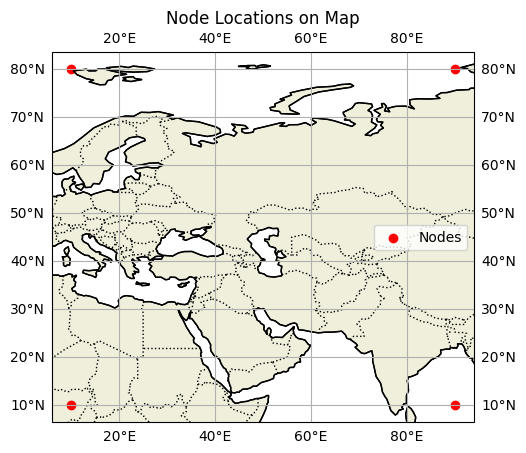

In [15]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
%matplotlib inline
# Define coordinates
node_lon = [90, 90, 10, 10]
node_lat = [80, 10, 10, 80]

# Create a map
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
# ax.set_extent([0, 120, 0, 90])  # Adjust extent based on your coordinates

# Add features
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot points
ax.scatter(node_lon, node_lat, color='red', marker='o', transform=ccrs.PlateCarree(), label="Nodes")

# Labels and grid
ax.set_title("Node Locations on Map")
ax.legend()
ax.gridlines(draw_labels=True)

plt.show()

ValueError: Grid unable to be represented in the UGRID conventions. Representing an unstructured grid requires at least the following variables: ['node_lon','node_lat', and 'face_node_connectivity']